# Satellite data (part 4)
----
J. Potemra
April 2022

----

# 3. Satellite winds: Ekman currents

Satellites can measure winds using a scatterometer, and this essentially measures the surface roughness, and from that winds can be derived.  Actually, this returns the _stress_ applied by the wind.  Wind stress is important as it drives ocean circulation.

The direct response of the ocean to winds is via [Ekman](https://en.wikipedia.org/wiki/Vagn_Walfrid_Ekman) currents.  The stress applied by the wind "pushes" the upper ocean, and Coriolis deflects the flow to the right in the Northern Hemisphere and to the left in the Southern Hemisphere.

In this notebook we will compute Ekman currents from surface winds.  Note that there are direct satellite measurements of stress, but as an exercise we'll start with speed.

We will use a blended NOAA/NCDC product from 
https://www.ncei.noaa.gov/thredds/blended-global/oceanWinds.html

__Background__
NOAA/NCDC Blended 6-hourly 0.25-degree Sea Surface Winds.  The data are created from multiple satellite observations: DMSP SSMI F08, F10, F11, F13, F14, F15; TMI; QuikSCAT; AMSR-E; Direction from NCEP Reanalysis-2

There is global ocean coverage with a 0.25-degree resolution. The whole datasets covers from July 1987 to present, 6-hourly resolution in this dataset; daily and monthly are also available in other directories. Include (u,v) means and scalar mean speed w for comparison.

Keywords: sea winds, ocean winds, sea surface winds, air-sea interaction, air-sea flux, wind-driven circulation, Ekman pumping, Ekman transport, ocean upwelling, wind stress, windstress

Reference links at http://www.ncdc.noaa.gov/oa/rsad/blendedseawinds.html

Simple spatiotemporally weighted Interpolation (SI), V.1.2. Version 1.2 uses updated satellite retrievals by Remote Sensing System, released in September 2006: SSMI V06, TMI V04, QSCAT V03a. AMSRE V05 was also updated using the new SSMI rain rate
institution: NOAA NESDIS National Climatic Data Center
Contact: Huai-Min.Zhang AT noaa.gov or satorder AT noaa.gov;         ph:1+828-271-4090
Acknowledgment: The gridded data were generated from the multiple satellite observations of DOD, NOAA and NASA (and future others) and wind retrievals of the Remote Sensing Systems, Inc. (http://www.remss.com), using scientific methods such as objective analysis (OA). The OA is only truly objective when the needed statistics are completely known, which may not be always the case.

Data_Calendar_Date: 2011-09-29

In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
# (can also use xarray)
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

In [2]:
# here we use the monthly file since it has a little better coverage and it easier to load
url = 'https://www.ncei.noaa.gov/thredds/dodsC/uv/monthly_agg/Aggregation_of_Monthly_Ocean_Wind_best.ncd'
dataset = nc.Dataset(url)

In [3]:
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.4, Unidata Dataset Discovery v1.0
    title: NOAA/NCDC Blended monthly 0.25-degree Sea Surface Winds
    source: Multiple satellite observations: DMSP SSMI F08, F10, F11, F13,F14 F15; TMI; QuikSCAT; AMSR-E; Direction from NCEP Reanalysis-2
    summary: Gridded and blended sea surface vector winds from multiple satellites with direction from NCEP Reanalysis-2; Global ocean coverage with a 0.25-degree resolution; The whole datasets covers from July 1987 to present, monthly resolution in this dataset; 6-hourly and daily are also available in other directories; See http://www.ncdc.noaa.gov/oa/rsad/blendedseawinds.html and links within for details. Include (u,v) means and scalar mean speed w for comparison
    Keywords: sea winds, ocean winds, sea surface winds, air-sea interaction, air-sea flux, wind-driven circulation, Ekman pumping, Ekman transport, ocean upwelling, wind st

In [4]:
# Like before, let's read data from a specific time, e.g.,
#  if timestep = 0, read the first time; timestep = -1,
#  read the last time
timestep = -1

# Extract the lat/lon/time arrays
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
time = dataset.variables['time'][:]

# Extract the zonal (u) and meridional (v) components of
#  wind speed. Note here that the data have an extra dimension, 
#  altitude, so we need to take that into account
uwind = dataset.variables['u'][timestep][0][:][:]
vwind = dataset.variables['v'][timestep][0][:][:]

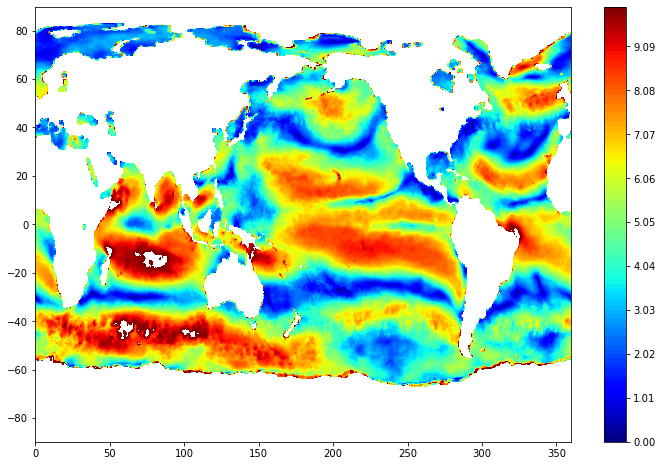

In [10]:
# make a quick plot of wind speed
plt.figure(figsize=(12,8))
#plt.contourf(lon,lat,np.sqrt(uwind*uwind+vwind*vwind), cmap = cm.jet)
#plt.colorbar();
# e.g. change contour levels
#plt.contourf(lon,lat,np.sqrt(uwind*uwind+vwind*vwind),
#             vmin = 0.0, vmax = 8.0, cmap = cm.jet)
my_levels = np.linspace(0.0,10.0,100)
plt.contourf(lon,lat,np.sqrt(uwind*uwind+vwind*vwind),
             levels=my_levels, cmap = cm.jet)
plt.colorbar();

## 3A. Compute Ekman flow

The first step in calculating the Ekman currents is obtaining wind stress from the wind velocity. Note that like veclocity, wind stress is a vector, and it is usually expressed with $\tau_{x}$ and $\tau_{y}$.

Wind stress can be parameterized as a function of a drag coefficient ($C_D$), wind speed ($w_{spd}$) and 10-meter wind velocity ($(u_{10},v_{10}$):

$\tau_{x} = \rho \: C_D \: u_{10} \: w_{spd}$

$\tau_{y} = \rho \: C_D \: v_{10} \: w_{spd}$

Where $\rho$ is the density of air (1.3 kg m-3), $(u_{10},v_{10})$ is the 10-meter wind velocity components, $w_{spd}$ is the wind speed at 10 m above sea level, and $C_D$ is the drag coefficient, given by [Yelland and Taylor, 1996](https://journals.ametsoc.org/view/journals/phoc/26/4/1520-0485_1996_026_0541_wsmfto_2_0_co_2.xml)

$1000 C_D = \left\{
\begin{array}{c l}     
    0.29 + \frac{3.1}{U_{10}} + \frac{7.7}{U_{10}^2} & 3 \le w_{spd} \le 6 \\
    0.60 + 0.070 U_{10} & 6 \le w_{spd} \le 26
\end{array}\right.$

In [11]:
# Compute the drag coefficient

# 1. compute wind speed from individual components
wspd = np.sqrt(uwind*uwind+vwind*vwind)

# 2. create an "empty" matrix the same size/shape as
#    wind speed
CD = np.ma.masked_all(wspd.shape, wspd.dtype)

# 3. fill the new matrix (CD) with values based on
#    different conditions
cond0 = (wspd < 3)
cond1 = (3 <= wspd) & (wspd < 6)
cond2 = (6 <= wspd) & (wspd <= 26)
cond3 = (wspd > 26)

CD[cond0] = 0.0028
CD[cond1] = (0.29 + (3.1/wspd[cond1]) + 7.7/wspd[cond1]**2)/1000.
CD[cond2] = (0.60 + 0.070*wspd[cond2])/1000.
CD[cond3] = 0.001

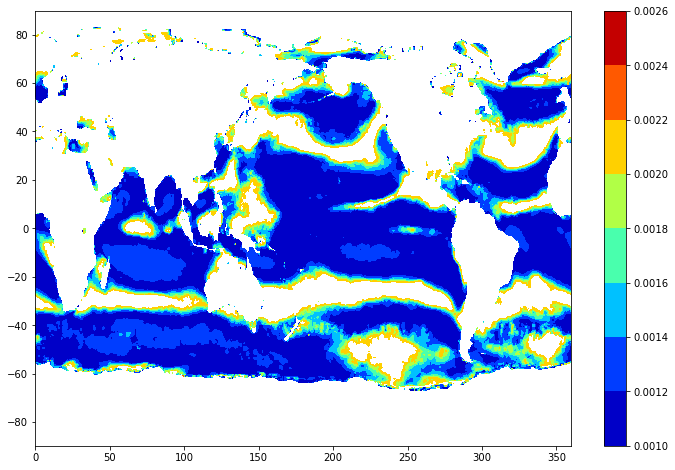

In [12]:
# again, make a quick plot
plt.figure(figsize=(12,8))
plt.contourf(lon,lat,CD,cmap = cm.jet)
plt.colorbar();

We can now calculate the wind stress:

In [13]:
rho = 1.3
taux = rho * CD * uwind * wspd
tauy = rho * CD * vwind * wspd
tau = np.sqrt(taux*taux+tauy*tauy)

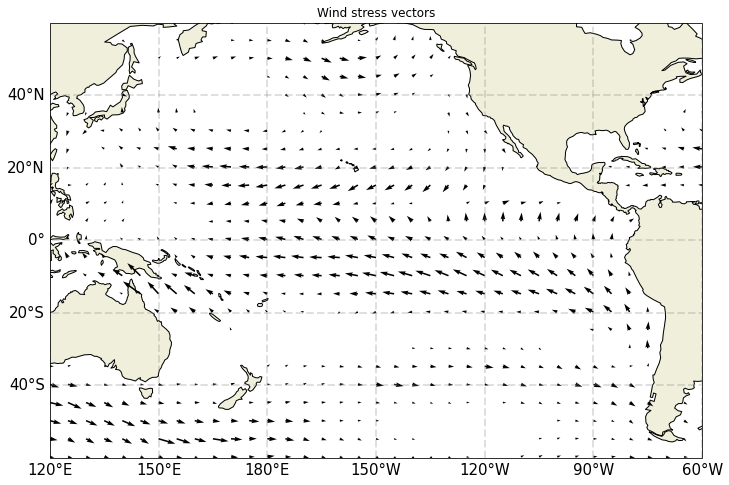

In [16]:
# now lets try make a plot
plt.figure(figsize=(12,8))

# use PlateCarree project and center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAND)
ax.set_extent([120, 300, -60, 60], crs=ccrs.PlateCarree())

# add grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# define exactly which ones to label
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150, -120, -90, -60])
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot wind stress as vectors
#  Note here we have a lot of data, so we will subset to
#  make the plot look more readable
plt.quiver(lon[::20],lat[::20],taux[::20,::20],tauy[::20,::20],
           transform=ccrs.PlateCarree())

ax.set_title('Wind stress vectors');

## 3B. Compute Ekman transport

From the zonal and meridional components we can calculate the [Ekman transport](https://en.wikipedia.org/wiki/Ekman_transport) using the following relations:

$M_x = \frac{\tau_y}{f}$

$M_y = -\frac{\tau_x}{f}$

Where $M_x$ is the zonal Ekman transport, $M_y$ is the meridional Ekman transport, and $f$ the Coriolis parameter and depends on the latitude:

$f = 2\Omega\sin(\theta)$

Where $\Omega$ is the angular velocity of the Earth and $\theta$ is latitude.

In [17]:
# Define Coriolis parameter
Omega = 2*np.pi/(24*60*60)
f = 2*Omega*np.sin(lat*np.pi/180.)

# Compute transport; Note we have to increase the
#  dimensions of variable f to be 2 instead of 1,
#  thus numpy newaxis
Mx = tauy/f[:,np.newaxis]
My = -taux/f[:,np.newaxis]

Note that the *zonal* component of the Ekman transport is related to the *meridional* component of the wind stress, and vice-versa. First, let's have a look at the Coriolis parameter.

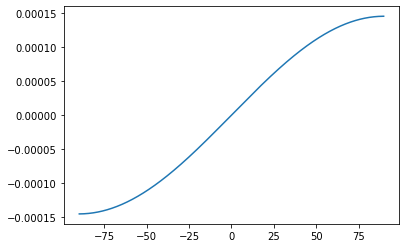

In [18]:
plt.plot(lat,f);

And now the Ekman transport

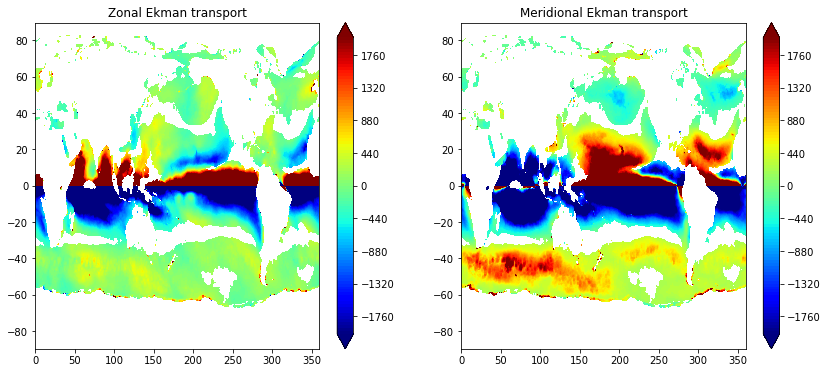

In [19]:
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
colors = plt.contourf(lon,lat,Mx,levels=np.linspace(-2000, 2000, 101), 
                      extend="both",cmap=cm.jet)
cb = plt.colorbar(colors)
ax1.set_label('kg s-1 m-1')
ax1.set_title('Zonal Ekman transport')

ax2 = plt.subplot(1,2,2)
colors = plt.contourf(lon,lat,My,levels=np.linspace(-2000, 2000, 101), 
                      extend="both",cmap=cm.jet)
cb = plt.colorbar(colors)
ax2.set_label('kg s-1 m-1')
ax2.set_title('Meridional Ekman transport');

/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/tmp/ipykernel_19731/2823541968.py:28: RuntimeWarning: invalid value encountered in sqrt
  color=np.sqrt(Mx*Mx+My*My),linewidth=2,density=5,


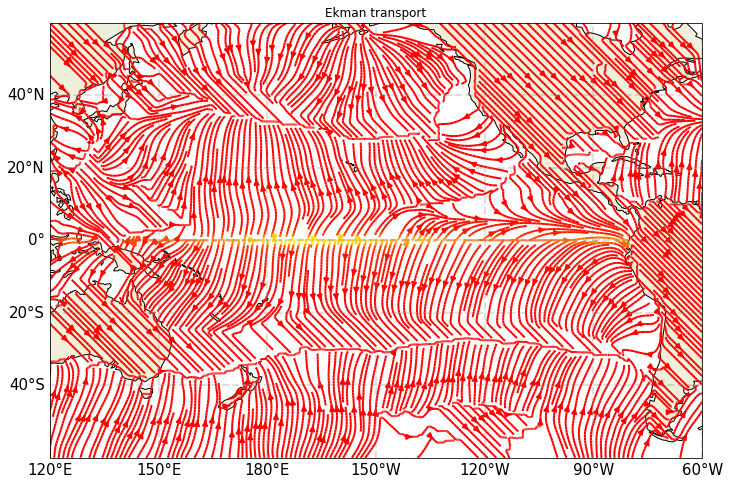

In [20]:
# try make a combined streamline plot
plt.figure(figsize=(12,8))

ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAND)
ax.set_extent([120, 300, -60, 60], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# define exactly which ones to label
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150, -120, -90, -60])
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# try a streamline plot
plt.streamplot(lon,lat,Mx,My,transform=ccrs.PlateCarree(),
               color=np.sqrt(Mx*Mx+My*My),linewidth=2,density=5,
               cmap=cm.autumn)

ax.set_title('Ekman transport');

One problem with the calculation of Ekman transport is that it tends to infinity close to the equator. Let's mask a band of 5 degrees around the equator:

/tmp/ipykernel_19731/3057798124.py:5: RuntimeWarning: invalid value encountered in sqrt
  Mmag = np.sqrt(Mx * Mx + My * My)
/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


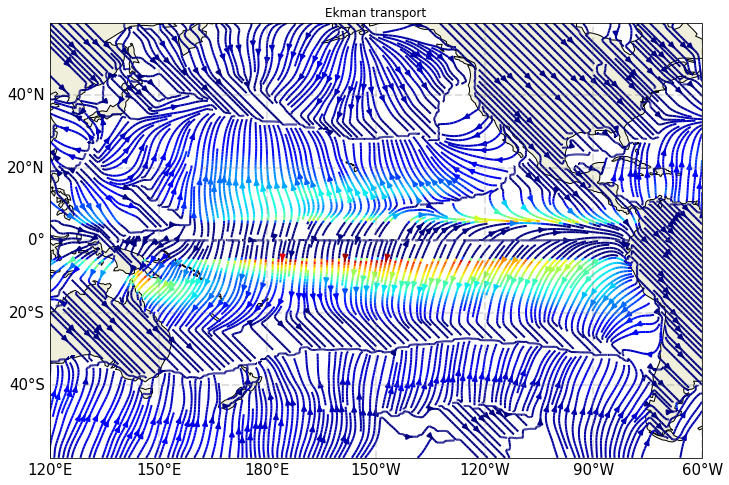

In [21]:
mask = np.abs(lat) < 5
lat2 = np.ma.masked_where(mask,lat)
Mx[mask] = np.ma.masked
My[mask] = np.ma.masked
Mmag = np.sqrt(Mx * Mx + My * My)

plt.figure(figsize=(12,8))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
ax.add_feature(cf.COASTLINE)                 
ax.add_feature(cf.LAND)
ax.set_extent([120, 300, -60, 60], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# now we define exactly which ones to label and spruce up the labels
gl.xlocator = mticker.FixedLocator([120, 150, 180, -150, -120, -90, -60])
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.streamplot(lon,lat2,Mx,My,transform=ccrs.PlateCarree(),color=Mmag,density=5,
               linewidth=2,cmap=cm.jet)

ax.set_title('Ekman transport');

# 4. Satellite data: Ocean color

There are several satellites that have measured ocean (and land surface) color.  Most of the data can be found at the NASA/Goddard Space Flight Center (GSFC);

https://oceancolor.gsfc.nasa.gov/

In this exercise we will make a quick plot of ocean color from MODIS-Aqua to investigate upwelling off California.


In [22]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
from matplotlib import cm

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import netcdf for working with OPeNDAP files
# (can also use xarray)
import netCDF4 as nc

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

In [29]:
# The data URL might be made more flexible by recognizing the syntax:
#  year/day of year
year = '2021'
doy = '105'
root_url = 'https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/'

In [30]:
URL = root_url + year + '/' + doy + '/A' + year + doy + '.L3m_DAY_CHL_chl_ocx_9km.nc'
file = nc.Dataset(URL)

In [31]:
# get all lat/lon/chl for a single day
lat = file.variables['lat'][:]
lon = file.variables['lon'][:]
chl = file.variables['chl_ocx'][:][:]

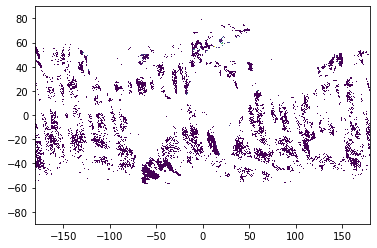

In [26]:
# quick-look at the data
plt.pcolormesh(lon,lat,chl)

In [32]:
# Subset for US West Coast

J = np.argwhere((lat>30)&(lat<40))
I = np.argwhere((lon>-125)&(lon<-115))

sub_lat = np.squeeze(lat[J])
sub_lon = np.squeeze(lon[I])
sub_chl = chl[int(J[0]):int(J[-1]+1),int(I[0]):int(I[-1])+1]

/tmp/ipykernel_19731/2735106568.py:1: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(sub_lon,sub_lat,np.log(sub_chl))


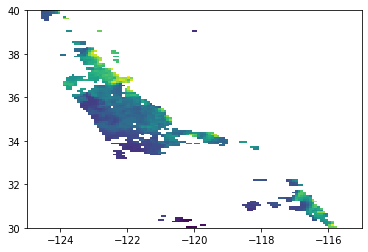

In [33]:
plt.pcolormesh(sub_lon,sub_lat,np.log(sub_chl))

/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/tljh/user/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/tmp/ipykernel_19731/3694947320.py:30: RuntimeWarning: invalid value encountered in log
  plt.contourf(sub_lon,sub_lat,np.log(sub_chl),cmap=cm.jet,


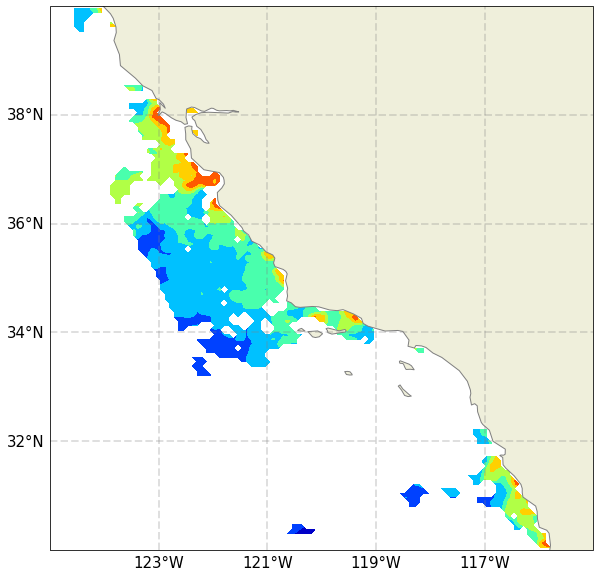

In [34]:
plt.figure(figsize=(10,10))

ax = plt.axes(projection = ccrs.PlateCarree())
#ax.add_feature(cf.COASTLINE)                 
#ax.add_feature(cf.LAND)
land_50m = cf.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cf.COLORS['land'])
ax.add_feature(land_50m, edgecolor='gray')

ax.set_extent([-125, -115, 30, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# now we define exactly which ones to label and spruce up the labels
gl.xlocator = mticker.FixedLocator([-125, -123, -121, -119, -117, -115])
gl.ylocator = mticker.FixedLocator([30, 32, 34, 36, 38, 40])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.contourf(sub_lon,sub_lat,np.log(sub_chl),cmap=cm.jet,
             transform=ccrs.PlateCarree())


# 5. OceanWatch data in Python

This tutorial will show the steps to grab data in ERDDAP from Python, how to work with NetCDF files in Python and how to make some maps and time-series od chlorophyll-a concentration around the main Hawaiian islands

## 5A. Downlading data from Python

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from R using the URL structure. For example, the following page allows you to subset monthly Chlorophyll a data from the Aqua-MODIS sensor https://oceanwatch.pifsc.noaa.gov/erddap/griddap/OceanWatch_aqua_chla_monthly.html. Select your region and date range of interest, then select the '.nc' (NetCDF) file type and click on "Just Generate the URL".

![](erddap.png)

In this specific example, the URL we generated is :
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2018-01-01T12:00:00Z):1:(2018-12-01T12:00:00Z)][(17):1:(30)][(195):1:(210)]

In Python, run the following to download the data using the generated URL :


In [35]:
import urllib.request
url="https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2018-01-01T12:00:00Z):1:(2018-12-01T12:00:00Z)][(17):1:(30)][(195):1:(210)]"
urllib.request.urlretrieve(url, "sst.nc")

('sst.nc', <http.client.HTTPMessage at 0x7fc50a51f1f0>)

## 5B. Importing NetCDF4 data in Python

Now that we've downloaded the data locally, we can import it and extract our variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

In [36]:
import xarray as xr
import netCDF4 as nc

- Open the file and load it as an xarray dataset:

In [37]:
ds = xr.open_dataset('sst.nc',decode_cf=False)

- examine the data structure:

In [38]:
ds

<xarray.Dataset>
Dimensions:       (time: 12, latitude: 261, longitude: 301)
Coordinates:
  * time          (time) float64 1.515e+09 1.517e+09 ... 1.541e+09 1.544e+09
  * latitude      (latitude) float32 17.02 17.08 17.12 ... 29.92 29.98 30.02
  * longitude     (longitude) float32 195.0 195.1 195.1 ... 209.9 210.0 210.0
Data variables:
    analysed_sst  (time, latitude, longitude) float64 ...
Attributes: (12/64)
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch program
    contributor_role:           Collecting source data and deriving products;...
    Conventions:                CF-1.6, ACDD-1.3, COARDS
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          2018-12-01T12:00:00Z
    time_coverage_resolution:   P1D
    time_coverage_start:        2018-01-01T12:00:00Z
    title:                      ZZZ - DEPRECATED - Sea Surface Temperature, C...
    Westernmost_Easting:        195.025

- examine which coordinates and variables are included in the dataset:

In [39]:
ds.coords

Coordinates:
  * time       (time) float64 1.515e+09 1.517e+09 ... 1.541e+09 1.544e+09
  * latitude   (latitude) float32 17.02 17.08 17.12 17.17 ... 29.92 29.98 30.02
  * longitude  (longitude) float32 195.0 195.1 195.1 195.2 ... 209.9 210.0 210.0

In [40]:
ds.data_vars

Data variables:
    analysed_sst  (time, latitude, longitude) float64 ...

- examine the structure of analysed_sst:

In [41]:
ds.analysed_sst.shape

(12, 261, 301)

Our dataset is a 3-D array with 261 rows corresponding to latitudes and 301 columns corresponding to longitudes,  for each of the 12 time steps.

- get the dates for each time step:

In [42]:
ds.time

<xarray.DataArray 'time' (time: 12)>
array([1.514808e+09, 1.517486e+09, 1.519906e+09, 1.522584e+09, 1.525176e+09,
       1.527854e+09, 1.530446e+09, 1.533125e+09, 1.535803e+09, 1.538395e+09,
       1.541074e+09, 1.543666e+09])
Coordinates:
  * time     (time) float64 1.515e+09 1.517e+09 1.52e+09 ... 1.541e+09 1.544e+09
Attributes:
    _CoordinateAxisType:    Time
    actual_range:           [1.5148080e+09 1.5436656e+09]
    axis:                   T
    coverage_content_type:  coordinate
    ioos_category:          Time
    long_name:              reference time of the sst field
    standard_name:          time
    time_origin:            01-JAN-1970 00:00:00
    units:                  seconds since 1970-01-01T00:00:00Z

In [43]:
dates = nc.num2date(ds.time, ds.time.units)
dates

array([cftime.DatetimeGregorian(2018, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 2, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 3, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 4, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 5, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 6, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 7, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 8, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 9, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 10, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 11, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2018, 12, 1, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)

## 5C. Working with the extracted data

### Creating a map for one time step

Let's create a map of SST for January 2018 (our first time step).

In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.warnings.filterwarnings('ignore')

- set some color breaks

In [45]:
np.nanmin(ds.analysed_sst)

17.922142857142862

In [46]:
np.nanmax(ds.analysed_sst)

28.390645161290323

In [47]:
levs = np.arange(17.5, 28.5, 0.05)

- define a color palette

In [48]:
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", 
     "red", "#7F0000"]

- set color scale using the jet palette

In [49]:
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

- plot the SST map

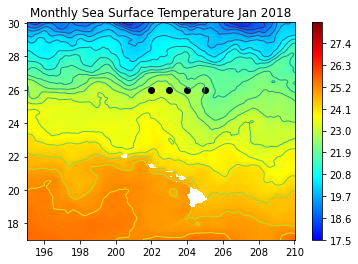

In [50]:
plt.contourf(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:], levs, cmap = cm)
#plot the color scale
plt.colorbar()
#example of how to add points to the map
plt.scatter(range(202,206),np.repeat(26,4),c='black')
#example of how to add a contour line
plt.contour(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:],levels=20,linewidths=1)
#plot title
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

### Plotting a time series

Let's pick the following box : 18-23N, 200-206E. We are going to generate a time series of mean SST within that box.

- first, let subset our data:

In [38]:
lat_bnds, lon_bnds = [18, 23], [200, 206]
da=ds.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

- let's plot the subset:

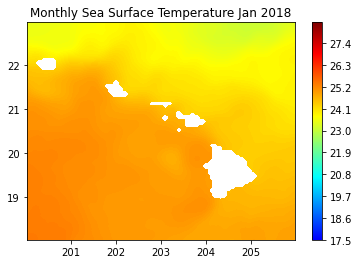

In [39]:
plt.contourf(da.longitude, da.latitude, da.analysed_sst[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

- let's compute the monthly mean over the bounding region:

In [40]:
res=np.mean(da.analysed_sst,axis=(1,2))

- let's plot the time-series:

TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeGregorian'

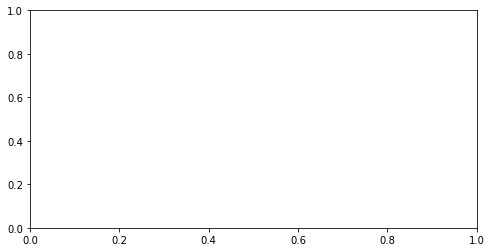

In [41]:
plt.figure(figsize=(8,4))
plt.scatter(dates,res)
plt.ylabel('SST (ºC)')

### Creating a map of average SST over a year

- let's compute the yearly mean for the region:

In [ ]:
mean_sst=np.mean(ds.analysed_sst,axis=0)

In [ ]:
mean_sst.shape

- let's plot the map of the 2018 average SST in the region:

In [ ]:
plt.contourf(ds.longitude, ds.latitude, mean_sst, levs,cmap=cm)
plt.colorbar()
plt.title("Mean SST " + dates[0].strftime('%Y-%m')+' - '+dates[11].strftime('%Y-%m'))
plt.show()

## 5D. Comparison of chlorophyll data from different sensors

Different ocean color sensors have been launched since 1997 to provide continuous global ocean color data. Unfortunately, because of differences in sensor design and calibration, chlorophyll-a concentration values don’t match during their periods of overlap, making it challenging to study long-term trends.

As an example, we are going to plot time-series of mean chlorophyll a concentration from various sensors from 1997 to 2019 to look at the periods of overlap. 
We are going to download data from Seawifs (1997-2010), MODIS (2002-2019) and VIIRS (2012-2019) and compare it to the ESA-CCI data (1997-2019) which combines all 3 sensors into a homogeneous time-series.

First, let's load all the packages needed:

In [51]:
import urllib.request 
import xarray as xr 
import netCDF4 as nc

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap 
np.warnings.filterwarnings('ignore')

The OceanWatch website has a data catalog containing documentation and links to all the datasets available:
https://oceanwatch.pifsc.noaa.gov/doc.html

Navigate to the "Ocean Color" tab. From there you can access the different datasets using ERDDAP or THREDDS.

### Get monthly seawifs data, which starts in 1997

Go to ERDDAP to find the name of the dataset for monthly SeaWIFS data: sw_chla_monthly_2018_0

You should always examine the dataset in ERDDAP to check the date range, names of the variables and dataset ID, to make sure your griddap calls are correct: https://oceanwatch.pifsc.noaa.gov/erddap/griddap/sw_chla_monthly_2018_0.html

Notice also that for this dataset and others, the latitudes are ordered from North to South, which will affect the construction of the download URL. (ie. instead of selecting latitudes 0-40N, you need to request 40-0).

- let's download data for a box around the Hawaiian Islands:

In [52]:
url='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/sw_chla_monthly_2018_0.nc?chlor_a[(1997-10-16T12:00:00Z):1:(2010-10-16T12:00:00Z)][(25):1:(15)][(198):1:(208)]'

In [ ]:
url

In [53]:
urllib.request.urlretrieve(url, "sw.nc")

('sw.nc', <http.client.HTTPMessage at 0x7fc50e41dc10>)

- let's use xarray to extract the data from the downloaded file:

In [54]:
sw_ds = xr.open_dataset('sw.nc',decode_cf=False)

In [55]:
sw_ds.data_vars

Data variables:
    chlor_a  (time, latitude, longitude) float32 ...

In [56]:
sw_ds.chlor_a.shape

(153, 121, 121)

The downloaded data contains only one variable: chlor_a.

- let's compute the monthly mean over the region and extract the dates corresponding to each month of data:

In [71]:
swAVG=np.mean(sw_ds.chlor_a,axis=(1,2))

swdates=nc.num2date(sw_ds.time,sw_ds.time.units,
                    only_use_cftime_datetimes=False) 

In [58]:
sw_ds.close()

### Get monthly MODIS data, that starts in 2002

In [59]:
url2='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_monthly_2018_0.nc?chlor_a[(2002-07-16T12:00:00Z):1:(2019-12-16T12:00:00Z)][(25):1:(15)][(198):1:(208)]'
urllib.request.urlretrieve(url2, "aq.nc")

('aq.nc', <http.client.HTTPMessage at 0x7fc50975b6a0>)

In [72]:
#aq_ds = xr.open_dataset('aq.nc',decode_cf=False)
#aqAVG=np.mean(aq_ds.chlor_a,axis=(1,2))

aqdates=nc.num2date(aq_ds.time,aq_ds.time.units,only_use_cftime_datetimes=False) 

In [61]:
aq_ds.chlor_a.shape

(210, 241, 241)

In [62]:
aq_ds.close()

### Get monthly VIIRS data, which starts in 2012

In [63]:
url3='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/noaa_snpp_chla_monthly.nc?chlor_a[(2012-01-02T12:00:00Z):1:(2019-12-01T12:00:00Z)][(25):1:(15)][(198):1:(208)]'
urllib.request.urlretrieve(url3, "snpp.nc")

('snpp.nc', <http.client.HTTPMessage at 0x7fc5096bb0a0>)

In [73]:
#snpp_ds = xr.open_dataset('snpp.nc',decode_cf=False)
#snppAVG=np.mean(snpp_ds.chlor_a,axis=(1,2))

snppdates=nc.num2date(snpp_ds.time,snpp_ds.time.units,only_use_cftime_datetimes=False) 

In [65]:
snpp_ds.chlor_a.shape

(96, 267, 268)

In [66]:
snpp_ds.close()

### Get OC-CCI data (September 1997 to Dec 2019)

In [67]:
url4='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v4-2.nc?chlor_a[(1997-09-04):1:(2019-12-01T00:00:00Z)][(25):1:(15)][(198):1:(208)]'
urllib.request.urlretrieve(url4, "cci.nc")

('cci.nc', <http.client.HTTPMessage at 0x7fc509b4b310>)

In [74]:
#cci_ds = xr.open_dataset('cci.nc',decode_cf=False)
#cciAVG=np.mean(cci_ds.chlor_a,axis=(1,2))
ccidates=nc.num2date(cci_ds.time,cci_ds.time.units,only_use_cftime_datetimes=False) 

In [69]:
cci_ds.close()

### Plot the data

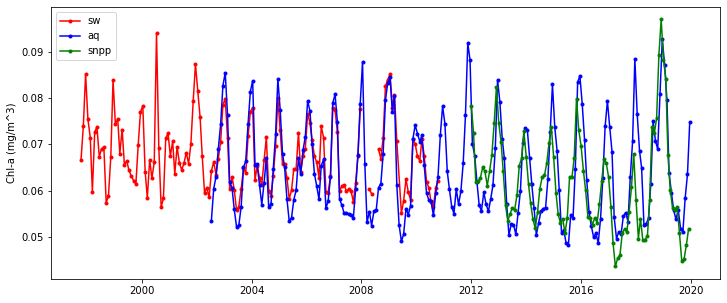

In [75]:
plt.figure(figsize=(12,5)) 
plt.plot(swdates,swAVG,label='sw',c='red',marker='.',linestyle='-')
plt.plot(aqdates,aqAVG,label='aq',c='blue',marker='.',linestyle='-')
plt.plot(snppdates,snppAVG,label='snpp',c='green',marker='.',
         linestyle='-')
plt.ylabel('Chl-a (mg/m^3)')
plt.legend()

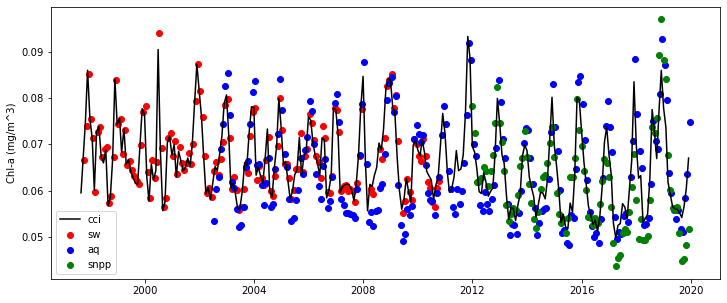

In [76]:
plt.figure(figsize=(12,5)) 
plt.plot(ccidates,cciAVG, label='cci',c='black')
plt.scatter(swdates,swAVG,label='sw',c='red')
plt.scatter(aqdates,aqAVG,label='aq',c='blue')
plt.scatter(snppdates,snppAVG,label='snpp',c='green')
plt.ylabel('Chl-a (mg/m^3)')
plt.legend()


## 5E.  Extract data within a shapefile using ERDDAP

This tutorial will teach you how to extract and display SST values for a particular time period or average SST over the whole time-series available within a shapefile.

The shapefile for the NOAA Marine National Monument and sanctuaries boundaries can be downloaded here: 
http://sanctuaries.noaa.gov/library/imast_gis.html. 
We are going to extract SST data for the Papahanaumokuakea Marine National Monument (PMNM) in Hawaii. However, because the Monument boundaries cross the dateline, the shapefile provided on the website is tricky to work with. We'll work with a cleaned up version, available here:
https://oceanwatch.pifsc.noaa.gov/files/PMNM_bounds.csv

### Load packages

In [ ]:
import pandas as pd
import numpy as np
import time
import urllib.request 
import xarray as xr 
import netCDF4 as nc
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point, Polygon
import geopandas as gpd

np.warnings.filterwarnings('ignore')

### Load the Monument boundary

In [ ]:
df=pd.read_csv('PMNM_bounds.csv')

Transform the boundary to a Polygon

In [ ]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
poly = Polygon([(p.x, p.y)  for p in  geometry])

In [ ]:
poly

### Data extraction

The example below extracts monthly 5km CoralTemp SST data within the monument boundary. 

- We are going to download data from ERDDAP for the smallest bounding box that contains our polygon

In [ ]:
xcoord1 = (np.min(df.lon), np.max(df.lon))
ycoord1 = (np.min(df.lat), np.max(df.lat))

- let's select a date range:

In [ ]:
tcoord = ("2019-01-15", "2019-12-15")

- and let's build our ERDDAP URL:

In [ ]:
url='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[('+ tcoord[0] +'):1:('+ tcoord[1] +')][('+ str(ycoord1[0]) +'):1:('+ str(ycoord1[1]) +')][(' + str(xcoord1[0]) +'):1:('+ str(xcoord1[1]) +')]'

In [ ]:
url

- now we can download the data:

In [ ]:
urllib.request.urlretrieve(url, "sst.nc")

- and load it as an xarray dataset:

In [ ]:
ds = xr.open_dataset('sst.nc',decode_cf=False)

In [ ]:
ds.analysed_sst.shape

We now have data for a box around our polygon, for 12 monthly time steps (= 1 year).

### Masking the data outside the Monument boundary

The .within() function from the shapelypackage checks if a point is within a polygon. We are using it to create a mask which will take the value 1 within the polygon boundary, and NaN outside.

(This takes about 1min or less to run).

In [ ]:
start_time=time.time()
mask=np.empty((len(ds.latitude.values),len(ds.longitude.values)))
mask[:]=np.NaN

for i in range(len(ds.latitude.values)):
    for j in range(len(ds.longitude.values)):
        p=Point(ds.longitude.values[j],ds.latitude.values[i],)     
        if int(p.within(poly))==1:
            mask[i,j]=int(p.within(poly))
            
end_time=time.time()
print("total time = %g mins" % ((end_time-start_time)/60.))

In [ ]:
plt.contourf(ds.longitude,ds.latitude,mask)

We now multiply the SST data we downloaded by the mask values:

In [ ]:
SST=ds.analysed_sst*mask

### Plotting the data

The extracted data contains several time steps (months) of sst data in the monument boundaries. Let's make a plot of the 4th time step for example.

- setting up the colormap

In [ ]:
np.min(SST),np.max(SST)

In [ ]:
levs = np.arange(16, 29, 0.05)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

- loading data to plot the coastline. The file can be downloaded [here](https://oceanwatch.pifsc.noaa.gov/files/gz_2010_us_outline_20m.json), and was provided by https://eric.clst.org/tech/usgeojson/.
Download the file and save it to your computer.

In [ ]:
# GeoJSON file downloaded from :
# https://eric.clst.org/tech/usgeojson/
country = gpd.read_file("gz_2010_us_outline_20m.json")
country.head()

- plot:

In [ ]:
country.plot(figsize=(12,8),color='black')
plt.xlim(-183,-153)
plt.ylim(18,32)
cs=plt.contourf(ds.longitude-360,ds.latitude,SST[4,:,:],levs,cmap=cm)
cbar=plt.colorbar(fraction=0.022)
cbar.ax.tick_params(labelsize=12) 
cs.ax.tick_params(labelsize=12)
plt.title('SST - April 2019', fontsize=20)

## 5F. Example of loading and working which an ESRI shapefile instead of .csv file

In [ ]:
from shapely.geometry import Point, Polygon

In [ ]:
import geopandas as gpd
import descartes
from matplotlib import pyplot as plt 
fp='C:\VM_Shared_Directory\OceanWatch\indicators\Monument\pmnm_Expanded_py_Albers\PMNM_py_files\hihwnms_py.shp'
data = gpd.read_file(fp)

data.plot(figsize=(14, 10))
plt.show()

In [ ]:
data

In [ ]:
data.geometry[0]

In [ ]:
p1=Point(-122.25,36.5)  #27.425 190.025
int(p1.within(data.geometry[0]))

## 5G. Extract data along a turtle track

This tutorial will teach you how to plot a loggerhead turtle track on a map.
That turtle was raised in captivity in Japan, then tagged and released on 05/04/2005 in the Central Pacific. It transmitted for over 3 years and went all the way to the Southern tip of Baja California!

The track data can be downloaded here:
https://oceanwatch.pifsc.noaa.gov/files/25317_05.dat

Then we'll extract SST and chlorophyll concentration at each location along the track, and plot the data.

### Load packages

In [81]:
import pandas as pd 
import numpy as np 
import urllib.request 
import xarray as xr 
import netCDF4 as nc 
import time
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap,BoundaryNorm,Normalize
#from mpl_toolkits.basemap import Basemap
from datetime import date,datetime

np.warnings.filterwarnings('ignore')

- Let's load the track data:

In [82]:
df=pd.read_csv('25317_05.dat')

FileNotFoundError: [Errno 2] No such file or directory: '25317_05.dat'

In [ ]:
df.head()

### Let's plot the track on a map:

In [ ]:
# Setup the bounding box for the zoom and bounds of the map
bbox=[120 ,255, 15, 55]
    
plt.figure(figsize=(10,10))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],\
            llcrnrlon=bbox[0],urcrnrlon=bbox[1],lat_ts=10,resolution='l')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='gray')

m.drawmeridians(np.arange(bbox[0], bbox[1], 10),labels=[0,0,0,1])
m.drawparallels(np.arange(bbox[2]+5, bbox[3], 10),labels=[1,0,0,0])

# build and plot coordinates onto map
x,y = m(list(df.mean_lon),list(df.mean_lat))
m.plot(x,y,color='k')
m.plot(x[0],y[0],marker='v',color='r')
m.plot(x[-1],y[-1],marker='^',color='g')
plt.title("Turtle #25317")
plt.show()

### Now let's extract data along the track

We are going to grab data from ERDDAP, so we need to set up the ERDDAP URLs using their datasets IDs and the name of the variables we are interested in.
Note that we are requesting the data as .csv

### Chlorophyll-a concentration

In [ ]:
MOD_d = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_1d_2018_0.csv?chlor_a"

Ideally, we would work with daily data since we have one location per day. But chlorophyll data is severely affected by clouds (i.e. lots of missing data), so you might need to use weekly or even monthly data to get sufficient non-missing data. 

Run all 3 of them, and plot a time-series of each to compare (as a separate exercise).

In [ ]:
MOD_w = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_8d_2018_0.csv?chlor_a" 
MOD_m = "https://oceanwatch.pifsc.noaa.gov/erddap/griddap/aqua_chla_monthly_2018_0.csv?chlor_a"

In [ ]:
lon=df.mean_lon
lat=df.mean_lat

We need to format the dates in a way that ERDDAP understands, i.e. 2010-12-15

In [ ]:
dates=[]
for i in range(len(df.month)):
    dates.append(date(df.year[i],df.month[i],df.day[i]).strftime('%Y-%m-%d'))

In [ ]:
dates[0]

For each date and location, we'll extract a value of CHL or SST. To do this, we need to pass those parameters (which dataset, which date, which lon, and which lat) to ERDDAP by building the URL.

This can take a long time to run (about 15 mins), we are making 1200+ requests to a remote server. For the purpose of the exercise, you can just run the below code on the first 100 points of the turtle track.

In [ ]:
start_time=time.time()
col_names =  ["date","matched_lat","matched_lon","matched_chla"]
tot=pd.DataFrame(columns = col_names)

for i in range(len(dates)):
#for i in range(5):
    print(i,len(dates))
    #this is where the URL is built:
    url=MOD_m+"[("+str(dates[i])+"):1:("+str(dates[i])+")][("+str(lat[i])+"):1:("+str(lat[i])+")][("+str(lon[i])+"):1:("+str(lon[i])+")]"
    new=pd.read_csv(url,skiprows=1)
    new.columns=col_names
    tot=tot.append(new,ignore_index=True)

end_time=time.time()


In [ ]:
print("total time = %g mins" % ((end_time-start_time)/60.))

In [ ]:
tot.head()

We now have a value of monthly chlorophyll-a concentration for each location/date combination along the turtle track.

## On your own!

- Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the following dataset:
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html


- Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/

Note! some ERDDAPs are slower than others, so this could take a lot longer. 
If it takes too long, adjust the "for" loop to request data for only the first 100 days of our track.

## Plot #2

Let's plot the track, color coded using values of monthly chlorophyll concentration.


- Let's create a color scale

In [ ]:
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 

- Let's look at the range of log of monthly chlorophyll values:

In [ ]:
np.min(np.log(tot.matched_chla)),np.max(np.log(tot.matched_chla))

In [ ]:
n, bins, patches=plt.hist(np.log(tot.matched_chla[~np.isnan(tot.matched_chla)]),50)
plt.show()

The range of log(chl-a) is -2.9 to 2.2 but most of the values are between -2.9 and 0. 

We use the log because the range of chlorophll values can be pretty big, with lots of very low values, and a few very high values.

In [ ]:
levs = np.append(np.arange(-2.9,0,0.1),2.2)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

BoundaryNorm will force the colorbar to use the breaks in levs.

In [ ]:
norm = BoundaryNorm(levs, len(levs))

In [ ]:
# Setup the bounding box for the zoom and bounds of the map
bbox=[120 ,255, 15, 55]
    
plt.figure(figsize=(10,10))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],\
            llcrnrlon=bbox[0],urcrnrlon=bbox[1],lat_ts=10,resolution='l')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='gray')

m.drawmeridians(np.arange(bbox[0], bbox[1], 10),labels=[0,0,0,1])
m.drawparallels(np.arange(bbox[2]+5, bbox[3], 10),labels=[1,0,0,0])

# build and plot coordinates onto map
x,y = m(list(df.mean_lon),list(df.mean_lat))
m.scatter(x,y,c=np.log(tot.matched_chla),cmap=cm,norm=norm)

m.plot(x[0],y[0],marker='v',color='r')
m.plot(x[-1],y[-1],marker='^',color='g')

#let's customize the color bar so the label reflect values of chl-a, not log(chl-a)
#we build levs2 to have the labels more spaced out than the values in levs
levs2=np.append(np.arange(-2.9,0,0.5),2.2)
cbar=m.colorbar(fraction=0.022,ticks=levs2, label='Chl a (mg/m^3))')
#and set the labels to be exp(levs2)
cbar.ax.set_yticklabels(np.around(np.exp(levs2),2))

plt.title("Turtle #25317")
plt.show()